In [ ]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib.ticker import LogLocator, FuncFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

!pwd
os.chdir("../../data")
path="train.parquet"
cluster_path = "steam_data_clustered.parquet"

/Users/isaac/Documents/GitHub/SteamStore-ANALYSE/Model/NLP


In [2]:
df = pd.read_parquet(path)
cluster = pd.read_parquet(cluster_path)

In [3]:
# Merge
df = pd.merge(df, cluster, on="app_id")

# description_courte
df = df.drop(columns=["description_courte_y"])
df = df.rename(columns={"description_courte_x": "description_courte"})

# tags_utilisateurs
df = df.drop(columns=["tags_utilisateurs_y"])
df = df.rename(columns={"tags_utilisateurs_x": "tags_utilisateurs"})
df["description_courte"] = df["description_courte"].astype(str)

df = df.loc[:, ~df.columns.duplicated()]
assert not df.columns.duplicated().any()

del cluster

In [4]:
emb_cols = [c for c in df.columns if c.startswith('emb_')]
df = df.loc[:, ~df.columns.str.startswith('emb')]
df = df.loc[:, ~df.columns.str.startswith('configuration')]

df["log_review"] = np.log1p(df["review"])
target_col = "review"
cluster = 'cluster_BERTopic'
groups = [df[df[cluster] == k][target_col] for k in df[cluster].unique()]

cluster_valide=[]

In [5]:
target_col = 'review'
cluster = 'cluster_BERTopic_K135'
for cluster in ["cluster","cluster_KPCA", "cluster_KPCA90"]:
    groups = [df[df[cluster] == k][target_col] for k in df[cluster].unique()]
    # Exécution du test F-oneway (ANOVA à un facteur)
    f_stat, p_value = stats.f_oneway(*groups)
    print(f" Cluster : {cluster}")  
    print(f"=== Résultat du test ANOVA sur {target_col}, Cluster : {cluster} ===")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4e}")

    if p_value < 0.05:
        cluster_valide.append(cluster)
        print("✅ RÉSULTAT SIGNIFICATIF : Les clusters textuels capturent bien des réalités économiques/qualitatives différentes.")
        print("   On rejette H0 : Les catégories ne sont pas juste visuelles, elles ont un impact réel sur la performance.")
    else:
        print("❌ Pas de différence significative détectée.")

 Cluster : cluster
=== Résultat du test ANOVA sur review, Cluster : cluster ===
F-statistic: 1.3238
P-value: 1.2215e-04
✅ RÉSULTAT SIGNIFICATIF : Les clusters textuels capturent bien des réalités économiques/qualitatives différentes.
   On rejette H0 : Les catégories ne sont pas juste visuelles, elles ont un impact réel sur la performance.
 Cluster : cluster_KPCA
=== Résultat du test ANOVA sur review, Cluster : cluster_KPCA ===
F-statistic: 1.1549
P-value: 9.8719e-02
❌ Pas de différence significative détectée.
 Cluster : cluster_KPCA90
=== Résultat du test ANOVA sur review, Cluster : cluster_KPCA90 ===
F-statistic: 1.2703
P-value: 1.5821e-02
✅ RÉSULTAT SIGNIFICATIF : Les clusters textuels capturent bien des réalités économiques/qualitatives différentes.
   On rejette H0 : Les catégories ne sont pas juste visuelles, elles ont un impact réel sur la performance.


In [6]:

target_col = 'review'
cluster = 'cluster_BERTopic_K135'
for cluster in ["cluster_BERTopic_K","cluster_BERTopic_K135","cluster_BERTopic"]:
    groups = [df[df[cluster] == k][target_col] for k in df[cluster].unique()]
    # Exécution du test F-oneway (ANOVA à un facteur)
    f_stat, p_value = stats.f_oneway(*groups)
    print(f" Cluster : {cluster}")  
    print(f"=== Résultat du test ANOVA sur {target_col}, Cluster : {cluster} ===")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4e}")

    if p_value < 0.05:
        cluster_valide.append(cluster)
        print("✅ RÉSULTAT SIGNIFICATIF : Les clusters textuels capturent bien des réalités économiques/qualitatives différentes.")
        print("   On rejette H0 : Les catégories ne sont pas juste visuelles, elles ont un impact réel sur la performance.")
    else:
        print("❌ Pas de différence significative détectée.")

 Cluster : cluster_BERTopic_K
=== Résultat du test ANOVA sur review, Cluster : cluster_BERTopic_K ===
F-statistic: 1.3446
P-value: 1.6794e-03
✅ RÉSULTAT SIGNIFICATIF : Les clusters textuels capturent bien des réalités économiques/qualitatives différentes.
   On rejette H0 : Les catégories ne sont pas juste visuelles, elles ont un impact réel sur la performance.
 Cluster : cluster_BERTopic_K135
=== Résultat du test ANOVA sur review, Cluster : cluster_BERTopic_K135 ===
F-statistic: 1.4510
P-value: 5.1610e-04
✅ RÉSULTAT SIGNIFICATIF : Les clusters textuels capturent bien des réalités économiques/qualitatives différentes.
   On rejette H0 : Les catégories ne sont pas juste visuelles, elles ont un impact réel sur la performance.
 Cluster : cluster_BERTopic
=== Résultat du test ANOVA sur review, Cluster : cluster_BERTopic ===
F-statistic: 0.8329
P-value: 9.9036e-01
❌ Pas de différence significative détectée.


In [7]:
# 1. Test d'homogénéité des variances (Bartlett)
# Le cours mentionne Bartlett 
for cluster in cluster_valide:
    groups = [df[df[cluster] == k][target_col] for k in df[cluster].unique()]
    stat_bartlett, p_bartlett = stats.bartlett(*groups)
    print(f"\nTest de Bartlett (Homoscédasticité) p-value: {p_bartlett:.4e} cluster : {cluster}")
    if p_bartlett < 0.05:
        print("⚠️ Attention : Les variances ne sont pas égales (hétéroscédasticité).")
        print("   Suggestion : Utiliser une ANOVA de Welch ou Kruskal-Wallis pour être robuste.")
        # Version robuste si Bartlett échoue (Bonus ++)
        # stat_kruskal, p_kruskal = stats.kruskal(*groups)

    # 2. Visualisation de la distribution des résidus (Optionnel mais recommandé)
    model = ols(f'{target_col} ~ C(cluster)', data=df).fit()
    sm.stats.anova_lm(model, typ=2) # Pour afficher la jolie table ANOVA comme page 33


Test de Bartlett (Homoscédasticité) p-value: 0.0000e+00 cluster : cluster
⚠️ Attention : Les variances ne sont pas égales (hétéroscédasticité).
   Suggestion : Utiliser une ANOVA de Welch ou Kruskal-Wallis pour être robuste.

Test de Bartlett (Homoscédasticité) p-value: 0.0000e+00 cluster : cluster_KPCA90
⚠️ Attention : Les variances ne sont pas égales (hétéroscédasticité).
   Suggestion : Utiliser une ANOVA de Welch ou Kruskal-Wallis pour être robuste.

Test de Bartlett (Homoscédasticité) p-value: 0.0000e+00 cluster : cluster_BERTopic_K
⚠️ Attention : Les variances ne sont pas égales (hétéroscédasticité).
   Suggestion : Utiliser une ANOVA de Welch ou Kruskal-Wallis pour être robuste.

Test de Bartlett (Homoscédasticité) p-value: 0.0000e+00 cluster : cluster_BERTopic_K135
⚠️ Attention : Les variances ne sont pas égales (hétéroscédasticité).
   Suggestion : Utiliser une ANOVA de Welch ou Kruskal-Wallis pour être robuste.


✅ Analyse ANOVA sur les 8 clusters dominants : [39, 160, 141, 16, 8, 78, 182, 269]


/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_62222/2497595884.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster, y=target_col , data=df_anova, palette='viridis', showfliers=False)


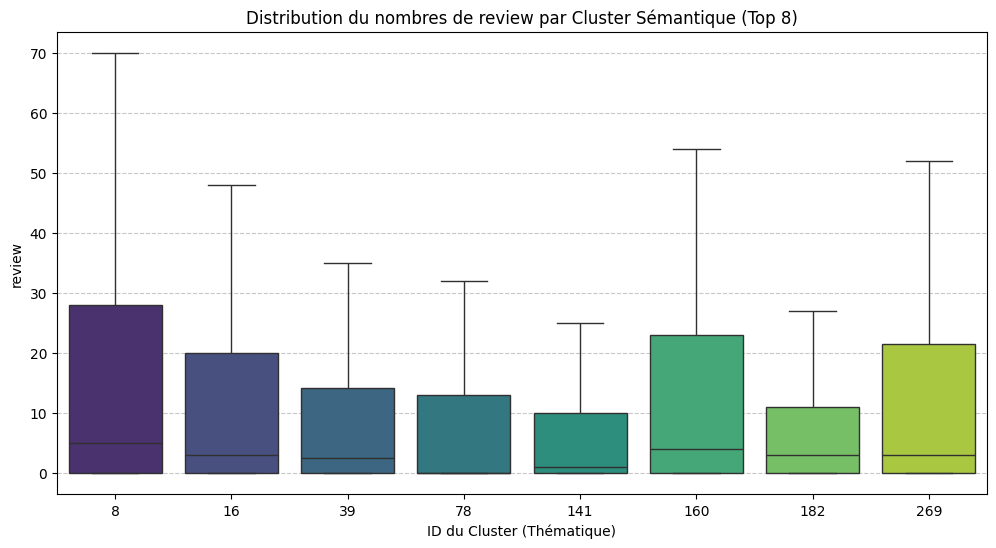


RÉSULTATS DU TEST ANOVA (Fisher) cluster : cluster
Variable testée : Metacritic Score
Groupes comparés : 8 plus gros clusters
F-statistic      : 1.4878
P-value          : 1.6668e-01
--------------------------------------------------
❌ CONCLUSION : Pas de différence significative.
✅ Analyse ANOVA sur les 8 clusters dominants : [83, 69, 99, 13, 85, 47, 84, 26]


/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_62222/2497595884.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster, y=target_col , data=df_anova, palette='viridis', showfliers=False)


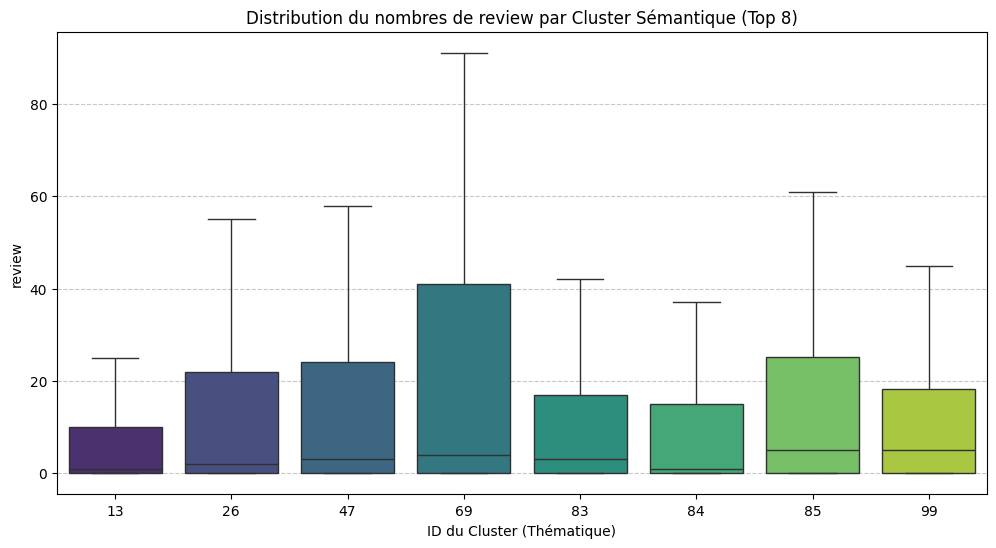


RÉSULTATS DU TEST ANOVA (Fisher) cluster : cluster_KPCA90
Variable testée : Metacritic Score
Groupes comparés : 8 plus gros clusters
F-statistic      : 1.2729
P-value          : 2.5943e-01
--------------------------------------------------
❌ CONCLUSION : Pas de différence significative.
✅ Analyse ANOVA sur les 8 clusters dominants : [0, 2, 1, 3, 5, 6, 4, 7]


/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_62222/2497595884.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster, y=target_col , data=df_anova, palette='viridis', showfliers=False)


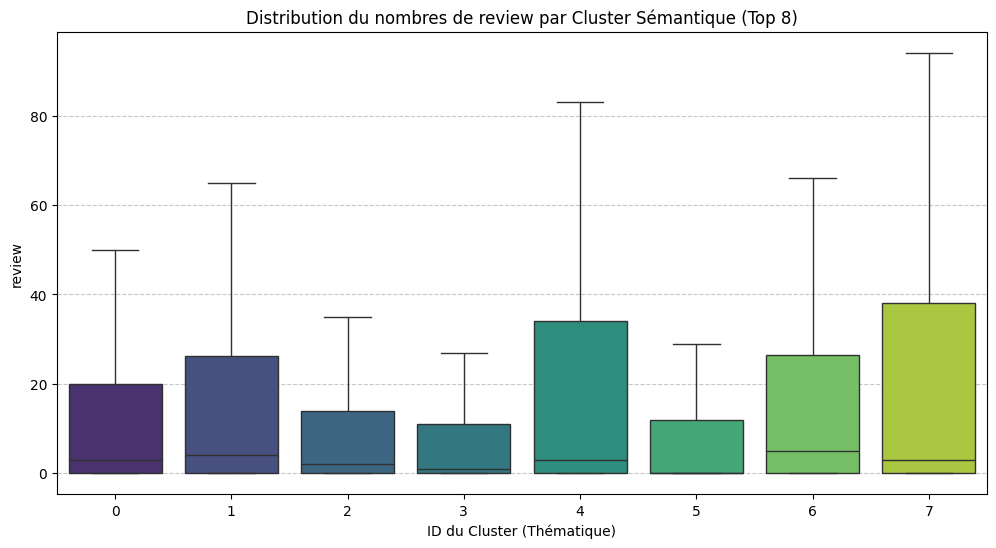


RÉSULTATS DU TEST ANOVA (Fisher) cluster : cluster_BERTopic_K
Variable testée : Metacritic Score
Groupes comparés : 8 plus gros clusters
F-statistic      : 2.1963
P-value          : 3.1659e-02
--------------------------------------------------
✅ CONCLUSION : Rejet de H0. Il y a une différence SIGNIFICATIVE.
   Les thématiques extraites du texte influencent bien la qualité perçue des jeux.
   (C'est ce que tu mets en GRAS dans ton slide)
✅ Analyse ANOVA sur les 8 clusters dominants : [0, 3, 2, 1, 4, 5, 8, 9]


/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_62222/2497595884.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster, y=target_col , data=df_anova, palette='viridis', showfliers=False)


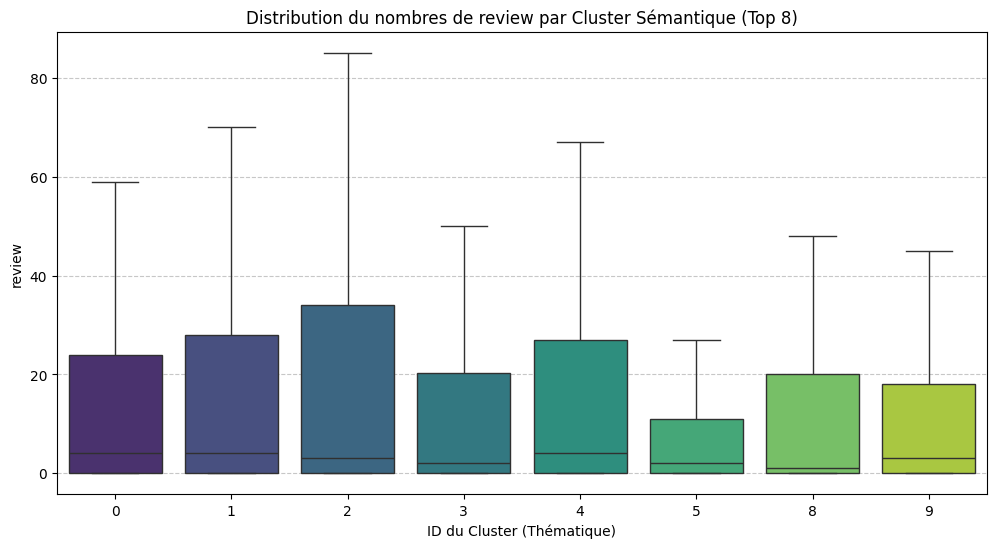


RÉSULTATS DU TEST ANOVA (Fisher) cluster : cluster_BERTopic_K135
Variable testée : Metacritic Score
Groupes comparés : 8 plus gros clusters
F-statistic      : 1.4237
P-value          : 1.9076e-01
--------------------------------------------------
❌ CONCLUSION : Pas de différence significative.


In [ ]:

# 1. Préparation : On sélectionne seulement les TOP clusters
# ---------------------------------------------------------
# On suppose que 'df' contient tes données avec la colonne cluster et target_col 
# Si ton df s'appelle autrement (ex: df_final), change le nom ici.
# On compte la taille de chaque cluster
for cluster in cluster_valide:
    cluster_sizes = df[cluster].value_counts()

    # On prend les 8 plus gros clusters (en ignorant le cluster -1 qui est le "bruit")
    top_clusters = cluster_sizes[cluster_sizes.index != -1].nlargest(8).index.tolist()

    print(f"✅ Analyse ANOVA sur les {len(top_clusters)} clusters dominants : {top_clusters}")

    # On filtre le DataFrame pour ne garder que ces clusters
    df_anova = df[df[cluster].isin(top_clusters)].copy()

    # 2. Visualisation pour le Slide (Boxplot)
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=cluster, y=target_col , data=df_anova, palette='viridis', showfliers=False)
    plt.title(f'Distribution du nombres de review par Cluster Sémantique (Top {len(top_clusters)})')
    plt.xlabel('ID du Cluster (Thématique)')
    plt.ylabel('review')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Sauvegarde pour ton rapport/slide
    plt.savefig('anova_boxplot_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Le Test Statistique (La preuve pour le 19/20)
    # ---------------------------------------------------------
    # On crée les groupes pour scipy
    groups = [df_anova[df_anova[cluster] == k][target_col].dropna() for k in top_clusters]

    # Test ANOVA (F-oneway)
    f_stat, p_value = stats.f_oneway(*groups)

    print("\n" + "="*50)
    print(f"RÉSULTATS DU TEST ANOVA (Fisher) cluster : {cluster}")
    print("="*50)
    print(f"Variable testée : Review")
    print(f"Groupes comparés : {len(top_clusters)} plus gros clusters")
    print(f"F-statistic      : {f_stat:.4f}")
    print(f"P-value          : {p_value:.4e}")  # .4e pour notation scientifique
    print("-" * 50)

    if p_value < 0.05:
        print("✅ CONCLUSION : Rejet de H0. Il y a une différence SIGNIFICATIVE.")
        print("   Les thématiques extraites du texte influencent bien la qualité perçue des jeux.")
        print("   (C'est ce que tu mets en GRAS dans ton slide)")
    else:
        print("❌ CONCLUSION : Pas de différence significative.")

Analyse Robustesse sur : cluster


/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_62222/2520583692.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster, y=target_col, data=df_anova, palette='viridis', showfliers=False) # showfliers=False rend le graphe plus lisible


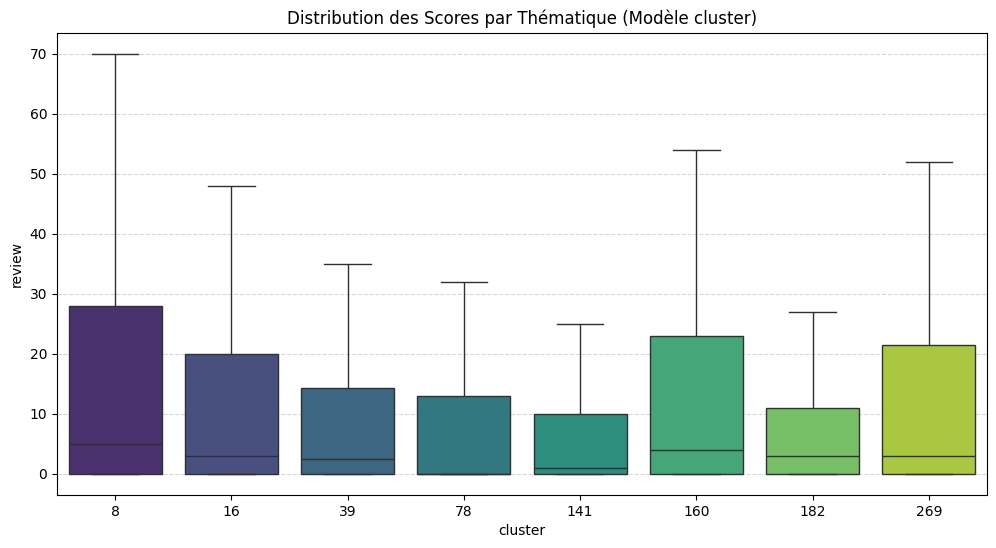


✅ RÉSULTAT DU TEST ROBUSTE (Kruskal-Wallis) pour cluster
Statistic H : 70.2038
P-value     : 1.3438e-12
 CONCLUSION SCIENTIFIQUE : H0 Rejetée.
   Même avec un test robuste (qui ne suppose pas l'égalité des variances),
   tes clusters séparent bien des jeux de qualités significativement différentes.
Analyse Robustesse sur : cluster_KPCA90


/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_62222/2520583692.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster, y=target_col, data=df_anova, palette='viridis', showfliers=False) # showfliers=False rend le graphe plus lisible


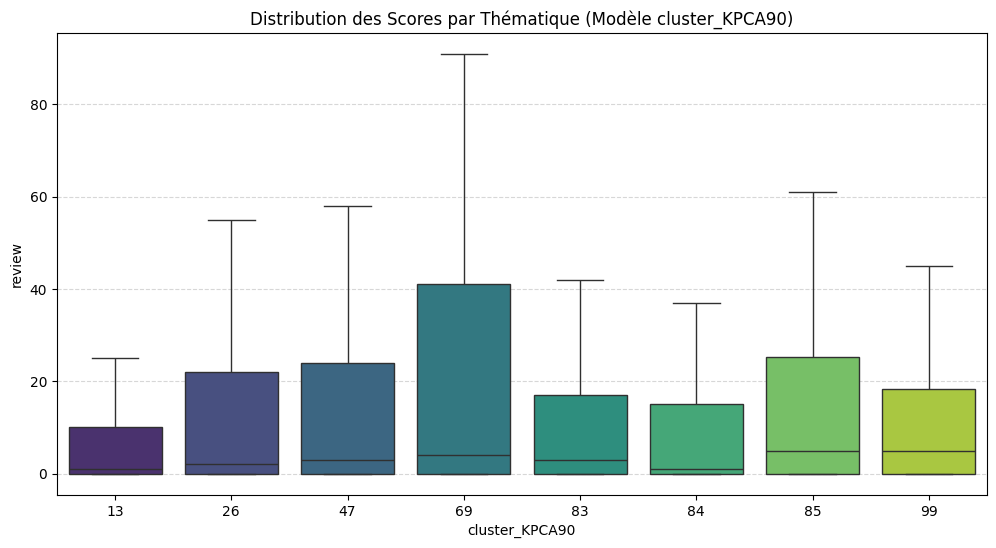


✅ RÉSULTAT DU TEST ROBUSTE (Kruskal-Wallis) pour cluster_KPCA90
Statistic H : 72.8481
P-value     : 3.9186e-13
 CONCLUSION SCIENTIFIQUE : H0 Rejetée.
   Même avec un test robuste (qui ne suppose pas l'égalité des variances),
   tes clusters séparent bien des jeux de qualités significativement différentes.
Analyse Robustesse sur : cluster_BERTopic_K


/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_62222/2520583692.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster, y=target_col, data=df_anova, palette='viridis', showfliers=False) # showfliers=False rend le graphe plus lisible


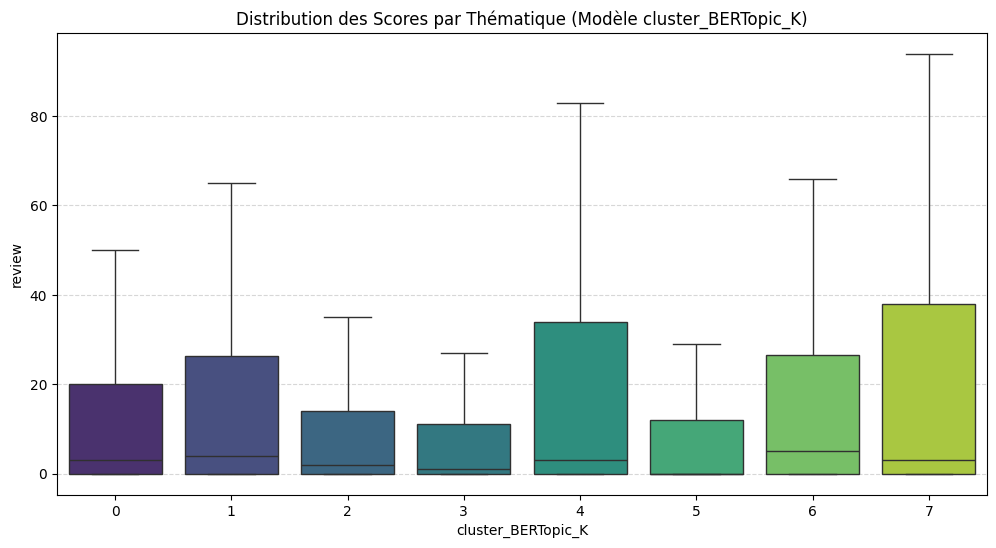


✅ RÉSULTAT DU TEST ROBUSTE (Kruskal-Wallis) pour cluster_BERTopic_K
Statistic H : 87.6626
P-value     : 3.7332e-16
 CONCLUSION SCIENTIFIQUE : H0 Rejetée.
   Même avec un test robuste (qui ne suppose pas l'égalité des variances),
   tes clusters séparent bien des jeux de qualités significativement différentes.
Analyse Robustesse sur : cluster_BERTopic_K135


/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_62222/2520583692.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster, y=target_col, data=df_anova, palette='viridis', showfliers=False) # showfliers=False rend le graphe plus lisible


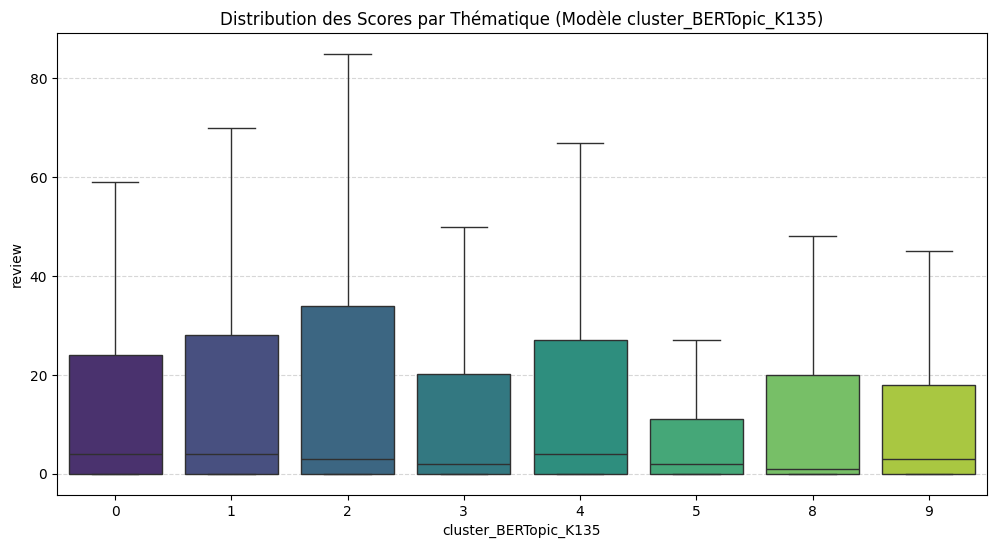


✅ RÉSULTAT DU TEST ROBUSTE (Kruskal-Wallis) pour cluster_BERTopic_K135
Statistic H : 60.1657
P-value     : 1.3988e-10
 CONCLUSION SCIENTIFIQUE : H0 Rejetée.
   Même avec un test robuste (qui ne suppose pas l'égalité des variances),
   tes clusters séparent bien des jeux de qualités significativement différentes.


In [9]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Ton modèle gagnant (selon tes logs)
meilleur_cluster = 'cluster_BERTopic_K' 

# Liste pour la boucle (ou juste ton meilleur)
#cluster_valide = [meilleur_cluster] 

for cluster in cluster_valide:
    # 1. Préparation des Top Clusters
    cluster_sizes = df[cluster].value_counts()
    top_clusters = cluster_sizes[cluster_sizes.index != -1].nlargest(8).index.tolist()
    
    df_anova = df[df[cluster].isin(top_clusters)].copy()
    
    print(f"Analyse Robustesse sur : {cluster}")
    
    # 2. Visualisation (Boxplot)
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=cluster, y=target_col, data=df_anova, palette='viridis', showfliers=False) # showfliers=False rend le graphe plus lisible
    plt.title(f'Distribution des Scores par Thématique (Modèle {cluster})')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.savefig(f'boxplot_{cluster}.png', dpi=300)
    plt.show()

    # 3. Création des groupes
    groups = [df_anova[df_anova[cluster] == k][target_col].dropna() for k in top_clusters]

    # 4. Le Test de la "Vérité Scientifique" (Kruskal-Wallis)
    # On utilise Kruskal car Bartlett a indiqué que les variances étaient inégales
    stat_k, p_k = stats.kruskal(*groups)

    print(f"\n✅ RÉSULTAT DU TEST ROBUSTE (Kruskal-Wallis) pour {cluster}")
    print(f"Statistic H : {stat_k:.4f}")
    print(f"P-value     : {p_k:.4e}")
    
    if p_k < 0.05:
        print(" CONCLUSION SCIENTIFIQUE : H0 Rejetée.")
        print("   Même avec un test robuste (qui ne suppose pas l'égalité des variances),")
        print("   tes clusters séparent bien des jeux de qualités significativement différentes.")
    else:
        print(" Pas de différence significative détectée avec le test robuste.")

In [19]:
import pandas as pd
import scipy.stats as stats

# ==============================================================================
# CONFIGURATION
# ==============================================================================
target_col = 'review'  # On évalue la Popularité (Engagement)
models_list = [
    'cluster',              # K-Means (Baseline)
    'cluster_KPCA',         # Kernel PCA
    'cluster_BERTopic',     # BERTopic (Défaut)
    'cluster_BERTopic_K',   # Ton Champion
    'cluster_BERTopic_K135' # Variante
]

# ==============================================================================
# BOUCLE DE TESTS STATISTIQUES COMPLETS
# ==============================================================================
results_full = []

print(f"Lancement du protocole de validation complet sur '{target_col}'...\n")

for model in models_list:
    if model not in df.columns:
        continue
        
    # 1. Préparation des Groupes (Top 8 pour la stabilité)
    # On prend les 8 clusters les plus peuplés pour éviter le bruit des micro-clusters
    counts = df[model].value_counts()
    top_clusters = counts[counts.index != -1].nlargest(8).index.tolist()
    
    # Création des listes de valeurs pour scipy
    groups = [df[df[model] == k][target_col].dropna() for k in top_clusters]
    
    # ---------------------------------------------------------
    # TEST 1 : BARTLETT (Vérification de l'Homoscédasticité)
    # H0 : Les variances sont égales (Condition requise pour ANOVA)
    # ---------------------------------------------------------
    stat_bart, p_bart = stats.bartlett(*groups)
    variance_egale = "✅ OUI" if p_bart > 0.05 else "❌ NON"
    
    # ---------------------------------------------------------
    # TEST 2 : ANOVA (Fisher) - Juste pour comparer
    # ---------------------------------------------------------
    stat_f, p_f = stats.f_oneway(*groups)
    
    # ---------------------------------------------------------
    # TEST 3 : KRUSKAL-WALLIS (Test Robuste)
    # Recommandé si Bartlett échoue
    # ---------------------------------------------------------
    stat_k, p_k = stats.kruskal(*groups)
    significatif = "✅ OUI" if p_k < 0.05 else "❌ NON"
    
    # Enregistrement des résultats
    results_full.append({
        'Modèle de Clustering': model,
        'Bartlett (p-val)': f"{p_bart:.2e}",
        'Homoscédastique ?': variance_egale,
        'ANOVA (F-stat)': f"{stat_f:.2f}",
        'Kruskal (H-stat)': f"{stat_k:.2f}",  # C'est ton score de performance
        'P-value (Kruskal)': f"{p_k:.2e}",
        'Significatif ?': significatif
    })

# ==============================================================================
# AFFICHAGE DU TABLEAU FINAL
# ==============================================================================
df_results = pd.DataFrame(results_full).sort_values('Kruskal (H-stat)', ascending=False)

print("=== SYNTHÈSE DES TESTS DE VALIDATION (Tableau Slide C6) ===")
display(df_results)

# Petit commentaire automatique pour te guider
winner = df_results.iloc[0]
print(f"\nCHAMPION : {winner['Modèle de Clustering']}")
print(f"   Score H : {winner['Kruskal (H-stat)']} (Plus c'est haut, mieux les clusters sont séparés).")
if winner['Homoscédastique ?'] == "❌ NON":
    print("   Note : Bartlett a échoué, l'usage de Kruskal était donc statistiquement OBLIGATOIRE.")

Lancement du protocole de validation complet sur 'review'...

=== SYNTHÈSE DES TESTS DE VALIDATION (Tableau Slide C6) ===


,Modèle de Clustering,Bartlett (p-val),Homoscédastique ?,ANOVA (F-stat),Kruskal (H-stat),P-value (Kruskal),Significatif ?
3,cluster_BERTopic_K,0.00e+00,❌ NON,2.20,87.66,3.73e-16,✅ OUI
0,cluster,0.00e+00,❌ NON,1.49,70.20,1.34e-12,✅ OUI
1,cluster_KPCA,0.00e+00,❌ NON,1.79,63.63,2.83e-11,✅ OUI
4,cluster_BERTopic_K135,0.00e+00,❌ NON,1.42,60.17,1.40e-10,✅ OUI
2,cluster_BERTopic,0.00e+00,❌ NON,1.46,50.71,1.05e-08,✅ OUI



CHAMPION : cluster_BERTopic_K
   Score H : 87.66 (Plus c'est haut, mieux les clusters sont séparés).
   Note : Bartlett a échoué, l'usage de Kruskal était donc statistiquement OBLIGATOIRE.


In [10]:
def top_tags_specifiques(
    df,
    col_tags,
    col_cluster,
    tags_a_exclure=None,
    top_k=3,
    eps=1e-9
):
    """
    Calcule la spécificité des tags pour chaque cluster.
    """
    # 1. Binarisation
    mlb = MultiLabelBinarizer(sparse_output=True)
    tags_matrix = mlb.fit_transform(df[col_tags])

    # 2. Création du DF sparse temporaire
    df_tags = pd.DataFrame.sparse.from_spmatrix(
        tags_matrix,
        columns=mlb.classes_
    )

    # 3. Gestion propre des clusters (conversion en int pour éviter les bugs de catégorie)
    # On utilise .values pour casser le lien avec l'index/type original
    try:
        df_tags['cluster'] = df[col_cluster].astype(int).values
    except:
        # Fallback si ce n'est pas convertible directement (ex: strings)
        df_tags['cluster'] = pd.to_numeric(df[col_cluster], errors='coerce').fillna(-1).astype(int).values

    # 4. Exclusion des Stop-Tags
    if tags_a_exclure:
        if isinstance(tags_a_exclure, str): tags_a_exclure = [tags_a_exclure]
        # On ne supprime que ceux qui existent
        cols_to_drop = [t for t in tags_a_exclure if t in df_tags.columns]
        if cols_to_drop:
            df_tags = df_tags.drop(columns=cols_to_drop)

    # 5. Agrégation
    counts_cluster = df_tags.groupby('cluster').sum()

    # Recalcul des tailles basé sur ce DF nettoyé pour être cohérent
    cluster_sizes = df_tags['cluster'].value_counts().sort_index()

    counts_global = df_tags.drop(columns=['cluster']).sum()
    total_docs = len(df)

    # 6. Probabilités et Lift
    P_t_c = counts_cluster.div(cluster_sizes, axis=0)
    P_t = counts_global / total_docs
    spec_score = P_t_c.div(P_t + eps, axis=1)

    # 7. Extraction
    rows = []
    for cluster_id in spec_score.index:
        # Ignorer le cluster bruit (-1) s'il traîne
        if cluster_id == -1: continue

        top_tags = spec_score.loc[cluster_id].nlargest(top_k)
        for tag, score in top_tags.items():
            rows.append({
                'Cluster': cluster_id,
                'Tag': tag,
                'Score_Specificite': round(score, 3),
                'P_tag_cluster': round(P_t_c.loc[cluster_id, tag], 3),
                'P_tag_global': round(P_t[tag], 3)
            })

    return pd.DataFrame(rows)

In [57]:
df_interpretation = top_tags_specifiques(
    df=df, 
    col_tags='tags_utilisateurs',      # La colonne des tags Steam
    col_cluster='cluster_BERTopic_K',  # Ton modèle gagnant
    top_k=5                            # Nombre de tags à afficher par cluster
)

# 2. On affiche le résultat pour les clusters les plus peuplés
# (On réutilise le calcul de taille précédent pour trier)
cluster_counts = df['cluster_BERTopic_K'].value_counts()
top_clusters_list = cluster_counts[cluster_counts.index != -1].nlargest(8).index.tolist()

print(f"=== INTERPRÉTATION DES 8 PLUS GROS CLUSTERS (Modèle Gagnant) ===")
print(f"Modèle analysé : cluster_BERTopic_K\n")

# Création d'un dictionnaire pour mapper ID -> Nom (utile pour les graphes !)
cluster_names = {}

for cluster_id in top_clusters_list:
    # Récupérer les tags du cluster
    tags = df_interpretation[df_interpretation['Cluster'] == cluster_id]['Tag'].tolist()
    
    # On crée un nom lisible (ex: "Action, FPS, Shooter")
    nom_cluster = ", ".join(tags[:3]) # On garde les 3 premiers
    cluster_names[cluster_id] = nom_cluster
    
    # Récupération des stats de performance (pour le commentaire)
    score_moyen = df[df['cluster_BERTopic_K'] == cluster_id]['review'].mean()
    
    print(f"🔹 Cluster {cluster_id} : [{nom_cluster}]")
    print(f"   • Tags complets : {', '.join(tags)}")
    print(f"   • Review Moyenne  : {score_moyen:.1f}")
    print("-" * 50)

=== INTERPRÉTATION DES 8 PLUS GROS CLUSTERS (Modèle Gagnant) ===
Modèle analysé : cluster_BERTopic_K

🔹 Cluster 0 : [Jump Scare, Thriller, Survival Horror]
   • Tags complets : Jump Scare, Thriller, Survival Horror, Psychological Horror, Supernatural
   • Review Moyenne  : 154.7
--------------------------------------------------
🔹 Cluster 2 : [Ninja, Elf, Platformer]
   • Tags complets : Ninja, Elf, Platformer, 2D Platformer, Precision Platformer
   • Review Moyenne  : 266.2
--------------------------------------------------
🔹 Cluster 1 : [Otome, Romance, Visual Novel]
   • Tags complets : Otome, Romance, Visual Novel, LGBTQ+, Dating Sim
   • Review Moyenne  : 82.6
--------------------------------------------------
🔹 Cluster 3 : [Precision Platformer, Unforgiving, Parkour]
   • Tags complets : Precision Platformer, Unforgiving, Parkour, Platformer, Time Attack
   • Review Moyenne  : 52.0
--------------------------------------------------
🔹 Cluster 5 : [Roguelike Deckbuilder, Dice, Deck

/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_62222/2769852390.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


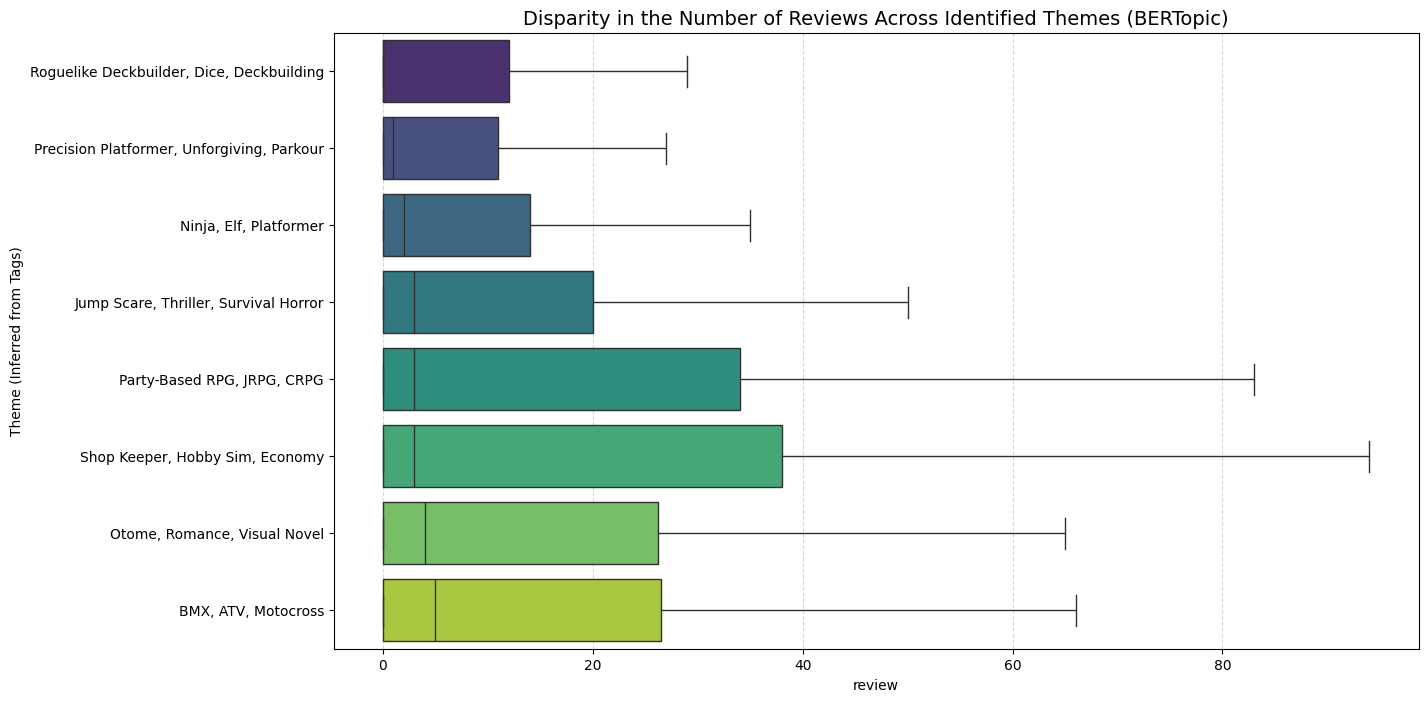

In [58]:
# 3. Le Graphe Final avec les vrais noms (La cerise sur le gâteau)
plt.figure(figsize=(14, 8))

# On filtre pour ne garder que les top clusters
df_final_plot = df[df['cluster_BERTopic_K'].isin(top_clusters_list)].copy()

# On remplace les chiffres par les noms générés plus haut
df_final_plot['Theme'] = df_final_plot['cluster_BERTopic_K'].map(cluster_names)

# Le Boxplot trié par note moyenne
order_by_score = df_final_plot.groupby('Theme')['review'].median().sort_values().index

sns.boxplot(
    x='review', 
    y='Theme',  # On met les noms en Y pour que ce soit lisible
    data=df_final_plot, 
    order=order_by_score,
    palette='viridis',
    showfliers=False
)

plt.title('Disparity in the Number of Reviews Across Identified Themes (BERTopic)', fontsize=14)
plt.xlabel('review')
plt.ylabel('Theme (Inferred from Tags)')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.savefig('final_boxplot_named.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 3. Le Graphe Final avec les vrais noms (La cerise sur le gâteau)
plt.figure(figsize=(14, 8))

# On filtre pour ne garder que les top clusters
df_final_plot = df[df['cluster_BERTopic_K'].isin(top_clusters_list)].copy()

# On remplace les chiffres par les noms générés plus haut
df_final_plot['Theme'] = df_final_plot['cluster_BERTopic_K'].map(cluster_names)

# Le Boxplot trié par note moyenne
order_by_score = df_final_plot.groupby('Theme')['review'].median().sort_values(ascending=True).index

sns.boxplot(
    x='review', 
    y='Theme',  # On met les noms en Y pour que ce soit lisible
    data=df_final_plot, 
    order=order_by_score,
    palette='viridis',
    showfliers=False
)

plt.title('Disparity in the Number of Reviews Across Identified Themes (BERTopic)', fontsize=14)
plt.xlabel('review')
plt.ylabel('Theme (Inferred from Tags)')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.savefig('final_boxplot_named.png', dpi=300, bbox_inches='tight')
plt.show()

🏆 Les 10 thématiques les plus virales (ID) : [85, 72, 79, 46, 139, 62, 148, 28, 35, 71]
🏷️ Génération des noms de thématiques (sans tags génériques)...


/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_62222/758314968.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


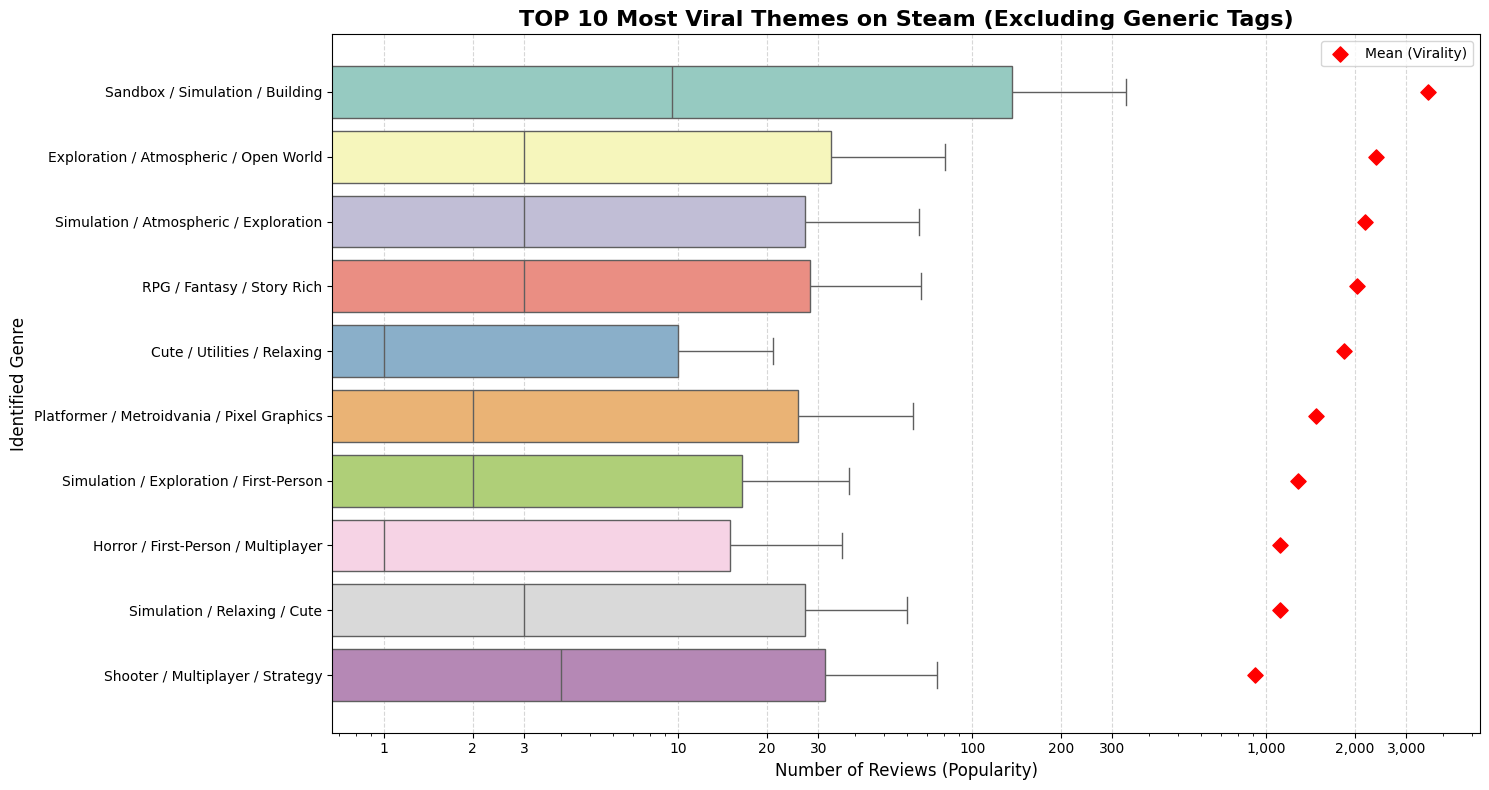

In [36]:
# ==============================================================================
# CONFIGURATION
# ==============================================================================
col_cluster = 'cluster_BERTopic_K'  # Ton modèle gagnant
target_col = 'review'               # Ta variable de popularité
top_k = 10                          # On veut le Top 10

# LISTE NOIRE : Les tags trop génériques à exclure
STOP_TAGS = ['Indie', 'Singleplayer', 'Casual', 'Action', 'Adventure', '2D', '3D']

# ==============================================================================
# 1. SÉLECTION DES TOP 10 CLUSTERS (Par Moyenne de Reviews)
# ==============================================================================
# On calcule la moyenne des reviews par cluster
mean_reviews = df.groupby(col_cluster)[target_col].mean().sort_values(ascending=False)

# On récupère les ID des 10 meilleurs
top_clusters_ids = mean_reviews.head(top_k).index.tolist()

print(f"🏆 Les {top_k} thématiques les plus virales (ID) : {top_clusters_ids}")

# On filtre le DataFrame pour ne garder que ces champions
df_top10 = df[df[col_cluster].isin(top_clusters_ids)].copy()

# ==============================================================================
# 2. NOMMAGE INTELLIGENT (Avec exclusion des Stop-Tags)
# ==============================================================================
def get_clean_cluster_label(cluster_id, df_source):
    # 1. On récupère tous les tags de tous les jeux de ce cluster
    tags_in_cluster = df_source[df_source[col_cluster] == cluster_id]['tags_utilisateurs'].explode()
    
    # 2. On retire les tags interdits (STOP_TAGS)
    tags_filtered = tags_in_cluster[~tags_in_cluster.isin(STOP_TAGS)]
    
    # 3. On prend les 3 plus fréquents restants
    top_tags = tags_filtered.value_counts().head(3).index.tolist()
    
    # Sécurité : si jamais il ne reste rien (cluster vide), on met "Unknown"
    if not top_tags:
        return f"Cluster {cluster_id}"
        
    return " / ".join(top_tags)

# Génération des noms nettoyés
print("🏷️ Génération des noms de thématiques (sans tags génériques)...")
cluster_names = {cid: get_clean_cluster_label(cid, df) for cid in top_clusters_ids}

# Application du mapping
df_top10['Theme'] = df_top10[col_cluster].map(cluster_names)

# ==============================================================================
# 3. VISUALISATION (Boxplot Final)
# ==============================================================================
plt.figure(figsize=(15, 8))

# Tri par popularité décroissante
order_by_mean = df_top10.groupby('Theme')[target_col].mean().sort_values(ascending=False).index

sns.boxplot(
    x=target_col, 
    y='Theme', 
    data=df_top10, 
    order=order_by_mean,
    palette='Set3',      # Palette "Feu" 
    showfliers=False       # On cache les outliers extrêmes pour la lisibilité
)

# Ajout des points rouges pour la moyenne (Indicateur de potentiel viral)
means = df_top10.groupby('Theme')[target_col].mean().reindex(order_by_mean)

plt.scatter(x=means, y=range(len(means)), color='red', s=60, label='Mean (Virality)', zorder=5, marker='D')

plt.title(f'TOP {top_k} Most Viral Themes on Steam (Excluding Generic Tags)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Reviews (Popularity)', fontsize=12)
plt.ylabel('Identified Genre', fontsize=12)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Mettre l'axe X en log
plt.xscale('log')

# Formatter pour afficher les valeurs réelles sur l'axe log
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0, subs=np.arange(1.0, 4.0)*0.1, numticks=5))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))


plt.tight_layout()
plt.savefig('top10_viral_clusters_clean_en_log_labels.png', dpi=300)
plt.show()

🏆 Les 10 thématiques les plus 'Sûres' (Médiane élevée) : [169, 158, 171, 168, 66, 147, 155, 174, 112, 85]


/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_62222/459774356.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


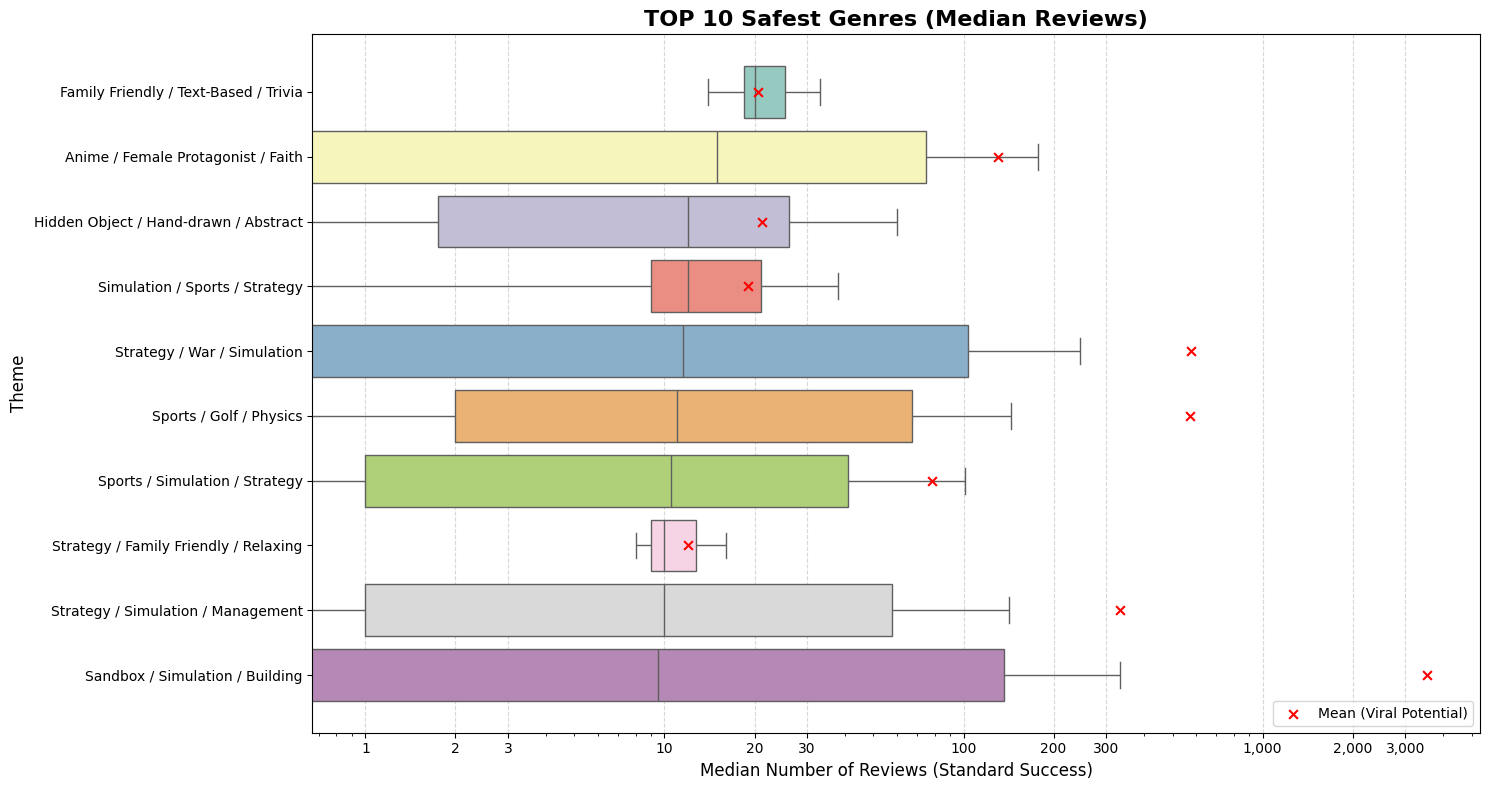

In [38]:
# ==============================================================================
# CONFIGURATION
# ==============================================================================
col_cluster = 'cluster_BERTopic_K'  # Ton modèle
target_col = 'review'               # Ta variable
top_k = 10                          # Top 10

# 🚫 LISTE NOIRE (Stop-Tags)
STOP_TAGS = ['Indie', 'Singleplayer', 'Casual', 'Action', 'Adventure', '2D', '3D']

# ==============================================================================
# 1. SÉLECTION DES TOP 10 PAR MÉDIANE (Le "Jeu Typique")
# ==============================================================================
# On calcule la MÉDIANE au lieu de la moyenne
median_reviews = df.groupby(col_cluster)[target_col].median().sort_values(ascending=False)

# On récupère les ID des 10 meilleurs (Ceux qui assurent un minimum de succès)
top_clusters_ids = median_reviews.head(top_k).index.tolist()

print(f"🏆 Les {top_k} thématiques les plus 'Sûres' (Médiane élevée) : {top_clusters_ids}")

# Filtre des données
df_top10 = df[df[col_cluster].isin(top_clusters_ids)].copy()

# ==============================================================================
# 2. NOMMAGE (Code identique à avant)
# ==============================================================================
def get_clean_cluster_label(cluster_id, df_source):
    tags_in_cluster = df_source[df_source[col_cluster] == cluster_id]['tags_utilisateurs'].explode()
    tags_filtered = tags_in_cluster[~tags_in_cluster.isin(STOP_TAGS)]
    top_tags = tags_filtered.value_counts().head(3).index.tolist()
    if not top_tags: return f"Cluster {cluster_id}"
    return " / ".join(top_tags)

cluster_names = {cid: get_clean_cluster_label(cid, df) for cid in top_clusters_ids}
df_top10['Theme'] = df_top10[col_cluster].map(cluster_names)

# ==============================================================================
# 3. VISUALISATION (Centrée sur la Médiane)
# ==============================================================================
plt.figure(figsize=(15, 8))

# Tri par Médiane décroissante
order_by_median = df_top10.groupby('Theme')[target_col].median().sort_values(ascending=False).index

# LE BOXPLOT
sns.boxplot(
    x=target_col, 
    y='Theme', 
    data=df_top10, 
    order=order_by_median,
    palette='Set3',    # Palette différente pour marquer le changement
    showfliers=False      # INDISPENSABLE : Cache les points extrêmes pour voir les boîtes
)

# On affiche la Moyenne (Point Rouge) ET la Médiane (Ligne de la boîte)
# Si la moyenne (rouge) est très loin à droite, ça montre le potentiel "Viral"
means = df_top10.groupby('Theme')[target_col].mean().reindex(order_by_median)
plt.scatter(x=means, y=range(len(means)), color='red', s=40, label='Mean (Viral Potential)', zorder=5, marker='x')

plt.title(f'TOP {top_k} Safest Genres (Median Reviews)', fontsize=16, fontweight='bold')
plt.xlabel('Median Number of Reviews (Standard Success)', fontsize=12)
plt.ylabel('Theme', fontsize=12)
plt.legend(loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.xscale('log')

# Formatter pour afficher les valeurs réelles sur l'axe log
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0, subs=np.arange(1.0, 4.0)*0.1, numticks=5))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))


plt.tight_layout()
plt.show()

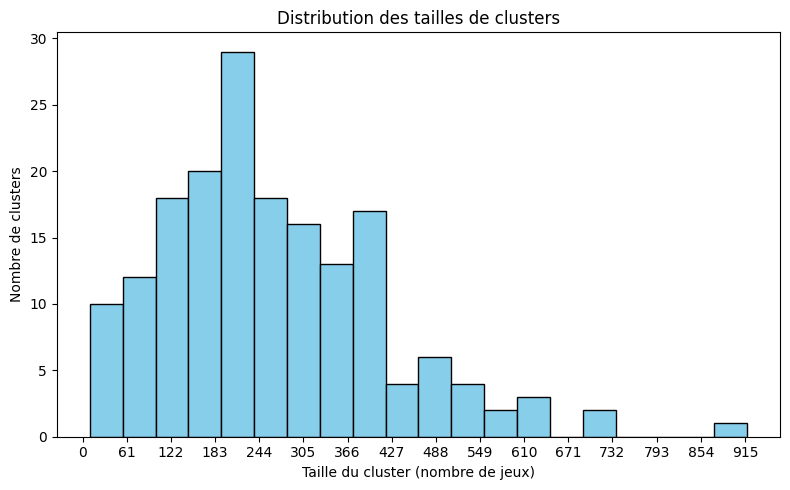

In [54]:
import matplotlib.pyplot as plt

# Exclure le cluster -1
cluster_sizes = df[df['cluster_BERTopic_K'] != -1]['cluster_BERTopic_K'].value_counts().values

plt.figure(figsize=(8,5))
plt.hist(cluster_sizes, bins=20, color='skyblue', edgecolor='black')

plt.xlabel("Taille du cluster (nombre de jeux)")
plt.ylabel("Nombre de clusters")
plt.title("Distribution des tailles de clusters")

# Ajouter plus de ticks sur l'axe des x pour mieux guider la lecture
plt.xticks(range(0, cluster_sizes.max() + 5, max(1, cluster_sizes.max() // 15)))

plt.tight_layout()
plt.show()